#Adapted from https://doi.org/10.1016/j.jenvman.2018.03.068 (Ref: Making the best use of experts' estimates to prioritise monitoring and management actions: A freshwater case study)
<h3>EVPI and EVPXI Calculation for ICU bed preparedness based on $R_0$, Case Seveirity and Child Infectiousness </h3>
Both single parameter and combined parameter analysis were carried out. <br>


&copy; Peter Eze


https://wiki.analytica.com/index.php?title=Expected_value_of_information_--_EVI,_EVPI,_and_ESVI&title=Expected_value_of_information_--_EVI,_EVPI,_and_ESVI

In [1]:
#Important library importation
import numpy as np
import warnings
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from itertools import chain

<h2> Data for Combined parameters' study</h2>
0 - CI05,1 - CI95, 2 - Mean

In [2]:
#Load output of Simulation Data from Excel Sheets

Tnga_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Tonga',header=None)
Tnga_df_T= Tnga_df.transpose()
reg1Payoffs = Tnga_df_T.values.tolist()
reg1CI95 = reg1Payoffs[1]

Ck_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Cooks Island',header=None)
Ck_df_T= Ck_df.transpose()
reg2Payoffs = Ck_df_T.values.tolist()

Smoa_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Samoa Rural',header=None)
Smoa_df_T= Smoa_df.transpose()
reg3Payoffs = Smoa_df_T.values.tolist()

fij_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Fiji Urban',header=None)
fij_df_T= fij_df.transpose()
reg4Payoffs = fij_df_T.values.tolist()
reg4CI95 = reg4Payoffs[1]
# Belief in each hypothesis or state of nature. This must sum to 1. It is a joint Probability distribution
Priors_df = pd.read_excel(r'C:\Users\ezep\Desktop\SPARKSPECTRUM\Data\EVPXIData2.xlsx', sheet_name='Priors',header=None)
Priors_df_T= Priors_df.transpose()
priorBeliefs = Priors_df_T.values.tolist()
beliefInStateAll = list(chain.from_iterable(priorBeliefs)) #flatten to 1-D array


C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [3]:
fij_df.tail()

,0,1,2
22,0.000000,102.06,38.37
23,0.000000,156.60,56.28
24,42.496132,1388.93,550.07
25,117.670179,1584.26,713.25
26,195.139626,1484.79,774.20


In [4]:
#Priors_df_T
priorBeliefs

[[0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035,
  0.037037037037037035],
 [0.5120000000000001,
  0.06400000000000002,
  0.06400000000000002,
  0.06400000000000002,
  0.008000000000000002,
  0.008000000000000002,
  0.06400000000000002,
  0.008000000000000002,
  0.008000000000000002,
  0.06400000000000002,
  0.008000000000000002,
  0.008000000000000002,
  0.008000000000000002,
  0.0010000000000000002,
  0.00100000000000000

In [434]:

print(priorBeliefs[5])

[0.018, 0.027, 0.045, 0.012, 0.018, 0.03, 0.03, 0.045, 0.075, 0.012, 0.018, 0.03, 0.008000000000000002, 0.012000000000000002, 0.020000000000000004, 0.020000000000000004, 0.03, 0.05, 0.03, 0.045, 0.075, 0.020000000000000004, 0.03, 0.05, 0.05, 0.075, 0.125]


<h2> Data for Individual parameters' study</h2>

In [29]:
#Region1 (Tonga) Data

severityData_r1 = [[0,0,0],[0,0,6.262393989],[0,0,1.54485] ] # used expectation over other parameters and MEdian action removed

r0Data_r1 = [[0,0,0],[0,3.968605431,2.293788558],[0,0.94731,0.59754]]

childInfData_r1 =[[0,0,0],[0,1.816137858,4.446256131],[0,0.37848,1.16637]]

#Region2 (Cooks) Data

severityData_r2 = [[0.023359134,0.48116139,0.862701594],[0.214861101,4.682551686,7.597196867],[0.08586,1.68276,2.78236]]

r0Data_r2 = [[0.075325835,0.947119047,0.344777236],[0.825536754,8.350923952,23.40497152],[0.2757,2.9939,1.28138]]

childInfData_r2 =[[0.110246187,0.79007772,0.466898211],[1.154459999,6.993229914,4.356614031],[0.40231,2.57604,1.57263]]

#Region3 (Sm rural) Data

severityData_r3 = [[0,0,0.108862806],[0,0.91309725,11.43892931],[0,0.12258,3.2473]]

r0Data_r3 = [[0,0,0.108862806],[0.321230772,7.160859531,4.869936256],[0.033,1.66194,1.67494]]

childInfData_r3 =[[0,0,0.108862806],[0.001605106,4.738426134,7.611995319],[0.00016,1.3215,2.04822]]

#Region4 (Fiji Urbam) Data

#Average (CI95 values) of values where severity = Low, Medium or High
severityData_r4 =  [0,65.0,982.89]  #[0,48.05,1609.28]- rejected method 0


#Average (CI95 values) of values where Ro = Low, Medium and  High
r0Data_r4 =[30.96, 451.12,565.82] 


childInfData_r4 =[265.0057687,381.8242251,401.0615308]

#Hypotheses or Beliefs in states of nature
severityBelief = [0.3, 0.2,0.5]
r0Belief = [0.3,0.2, 0.5]
childInfBelief = [0.3, 0.2, 0.5]

#Excess allocation to COVID - Scaling factor
gammas = np.arange(0,1.1,0.1) # from 0 to 1

allAnalysisTypes = ["Severity"] #["Severity","R0","ChildInf","All"] 
allRegions = ["Region4"]#,"Region1", "Region2", "Region3","Region4"

<H3> Helper Functions</h3?

In [6]:

def EVUncertainty(payoff,beliefs):
    return np.dot(payoff,beliefs)
def renormaliseBeliefs(otherBeliefs,falseBelief):
    return np.divide(otherBeliefs,falseBelief)
def removeCurrentPayoffs(payOfs,location):
    del payOfs[location] 
    return payOfs
def getActionName(actionNumber):
    nm =""
    if actionNumber == 0:
        nm = 'Do Nothing'
    elif actionNumber == 1:
        nm = 'Increment50'
    elif actionNumber == 2:
        nm = 'Increment100'
    elif actionNumber == 3:
        nm = 'Increment150'
    elif actionNumber == 4:
        nm = 'Increment200'
    return nm    
def loadExperiment(reg,anaType,befielfDistribution):
    global beliefInState,priorBeliefs
    global payoffs
    global labels #For ploting of VoI Results especially EVPXI
    if anaType=="Severity":
        beliefInState=severityBelief
        priorBeliefs = beliefInState
        labels =['SevLow','SevMedium','SevHigh']
        if reg =="Region1":
            payoffs = severityData_r1
        elif reg =="Region2":
            payoffs = severityData_r2
        elif reg =="Region3":
            payoffs = severityData_r3
        elif reg =="Region4":
            payoffs = severityData_r4
    elif anaType=="R0":
        beliefInState=r0Belief
        priorBeliefs = beliefInState
        labels =['R0Low','R0Medium','R0High']
        if reg =="Region1":
            payoffs = r0Data_r1
        elif reg =="Region2":
            payoffs = r0Data_r2
        elif reg =="Region3":
            payoffs = r0Data_r3
        elif reg =="Region4":
            payoffs = r0Data_r4
    elif anaType=="ChildInf":
        beliefInState=childInfBelief
        priorBeliefs = beliefInState
        labels =['ChildInfLow','ChildInfMedium','ChildInfHigh']
        if reg =="Region1":
            payoffs = childInfData_r1
        elif reg =="Region2":
            payoffs = childInfData_r2
        elif reg =="Region3":
            payoffs = childInfData_r3
        elif reg =="Region4":
            payoffs = childInfData_r4
    elif anaType=="All":
        beliefInState= priorBeliefs[befielfDistribution]
        labels = ['S1', 'S2', 'S3','S4', 'S5', 'S6','S7', 'S8', 'S9','S10', 'S11', 'S12','S13', 'S14', 'S15','S16', 'S17', 'S18',
         'S19', 'S20', 'S21','S22', 'S23', 'S24', 'S25', 'S26', 'S27']
        if reg =="Region1":
            payoffs = reg1Payoffs[1] # CI95 outputs
        elif reg =="Region2":
            payoffs = reg3Payoffs[1]
        elif reg =="Region3":
            payoffs = reg3Payoffs[1]
        elif reg =="Region4":
           payoffs = reg4Payoffs[1]

def validateInputs():
    chk = round(np.sum(np.array(beliefInState)),2)
    if chk != 1:
        warnings.warn('Belief in State is not a probability distribution')
    print(f"Sum of probabilities = {chk}")
    if numOfStates != payoffNum[0]:
        warnings.warn('Number of States of nature must equal number of Payoffs for each action alternative')
        print(f"Number of states = {numOfStates}, Number of payoff per action = {payoffNum[1]}")

def computeLostLifeYears(numberOfInitialICUBeds,numberOfICUBedsToAdd,costOfICUBed,lifeGainedPerICUBeds):
    lly = 0
    
def newPayoff(requiredBeds,incrementByBeds,scaleBy):
    us = requiredBeds - incrementByBeds
    if us < 0:
        us = abs(us)*scaleBy
    return us
def generateNewPayoffs(scaleFactor):
    for i in range(numberOfActions):
        for j in range(numOfStates):
            updatedPayoffs[i][j] = newPayoff(payoffs[j],actions[i],scaleFactor)
    return updatedPayoffs

<h2> Select and load data for the specific analysis in a Region </h2>

In [30]:
#Select The Region and Type of Analysis (Parameter) to analyse in this run
analysisType = 'Severity' #All,Severity,R0,ChildInf
region = 'Region4' #Region1, Region2, Region3, Region4
befielfDistrib = 5 # 5 is strong believe in Severe Outbreak
payoffs = []
beliefInState = []
labels = []
loadExperiment(region,analysisType,befielfDistrib) #Use the selected input to load the appropriate payoff and probabilities

In [8]:
#View loaded data before running experiments
print(payoffs)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 345.37, 0.0, 0.0, 0.0, 0.0, 28.72, 74.25, 552.26, 1074.63, 1405.76, 0.0, 0.0, 0.0, 46.23, 102.06, 156.6, 1388.93, 1584.26, 1484.79]


In [9]:
print(beliefInState,priorBeliefs)

[0.018, 0.027, 0.045, 0.012, 0.018, 0.03, 0.03, 0.045, 0.075, 0.012, 0.018, 0.03, 0.008000000000000002, 0.012000000000000002, 0.020000000000000004, 0.020000000000000004, 0.03, 0.05, 0.03, 0.045, 0.075, 0.020000000000000004, 0.03, 0.05, 0.05, 0.075, 0.125] [[0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035], [0.5120000000000001, 0.06400000000000002, 0.06400000000000002, 0.06400000000000002, 0.008000000000000002, 0.008000000000000002, 0.06400000000000002

In [10]:
#Validate Inputs
actions = np.arange(0,201,50) # Increment ICU bed by action(a) to prepare for outbreak
payoffNum = np.array(payoffs).shape
numOfStates = len(beliefInState)
numberOfActions = len(actions)
updatedPayoffs =[[0 for i in range(numOfStates)] for j in range(numberOfActions) ] #updatedPayoffs  = [numberOfActions][numOfStates]
validateInputs()

Sum of probabilities = 1.0


In [20]:
#Create the new payoff matrix using the actions and the CI95 out of simulation for each of the hypothesis
scaleBy = 0.7
updatedPayoffs = generateNewPayoffs(scaleBy)


In [21]:
print(np.array(updatedPayoffs).shape) #Shape of the payoff matrix : n actions by m states of nature or hypotheses
        

(5, 27)


In [22]:
print(f"One of the {numberOfActions} actions will be chosen for each of the {numOfStates} States of nature to achieve one or more of the management objectives")
    

One of the 5 actions will be chosen for each of the 27 States of nature to achieve one or more of the management objectives


In [23]:
print(updatedPayoffs)


[[0.0, 0.0, 0.0, 0.0, 0.0, 6.530841, 0.0, 0.0, 272.073685, 0.0, 0.0, 0.0, 21.16927, 48.051289, 130.693491, 716.283133, 1609.279079, 1534.607034, 0.0, 0.0, 0.0, 51.166078, 146.513512, 180.856062, 1596.433437, 1632.574146, 1484.792664], [35.0, 35.0, 35.0, 35.0, 35.0, 30.428411299999997, 35.0, 35.0, 222.073685, 35.0, 35.0, 35.0, 20.181510999999997, 1.364097700000002, 80.693491, 666.283133, 1559.279079, 1484.607034, 35.0, 35.0, 35.0, 1.1660779999999988, 96.51351199999999, 130.856062, 1546.433437, 1582.574146, 1434.792664], [70.0, 70.0, 70.0, 70.0, 70.0, 65.4284113, 70.0, 70.0, 172.073685, 70.0, 70.0, 70.0, 55.181511, 36.3640977, 30.693490999999995, 616.283133, 1509.279079, 1434.607034, 70.0, 70.0, 70.0, 34.1837454, 46.51351199999999, 80.85606200000001, 1496.433437, 1532.574146, 1384.792664], [105.0, 105.0, 105.0, 105.0, 105.0, 100.4284113, 105.0, 105.0, 122.07368500000001, 105.0, 105.0, 105.0, 90.18151099999999, 71.3640977, 13.514556300000002, 566.283133, 1459.279079, 1384.607034, 105.0, 1

In [445]:
print(actions)

[  0  50 100 150 200]


<h1>Perform VoI Analysis</h1>
This includes Expected value of Perfect Information (EVPI) and Expected Value of Partial Information (EVPXI)<p>
    <b>V(a, s) </b> is the cost of an action, $a$, for a given state of nature, $s$, as computed from the simulation of the Transmission model. </p>
    <p>
    <b>B</b> is the total number of ICU patients that can be provided with ICU beds using the monetary budget, $L$.</p> 
    <p>
    <b>$P_s$</b> is the belief in the hypothesis or state of nature, $s$. </p>
    <p>
    <b>$N$</b> Number of Hypotheses or States of Nature considered. $ N=27$ for combined parameters and 3 for Individual Parameters. </p>
                                                    

<h3>Compute EVPI</h3>
$EVPI=EV_{certainty}-EV_{uncertainty} $ 

$EV_{uncertainty}=Min_a |\{\sum_{s=1}^N V(a,s).p_s \}|$

$EV_{certainty} ={\sum_{s=1}^N Min_a |V(a,s) |.p_s }$

$U(s) = V(s) - B_a$

$V(a,s) = \gamma *| U(s) |$ if $U(a,s) < 0 $

$V(a,s) =  * U(s)$, otherwise.

In [415]:
print(np.array(priorBeliefs).shape[0])

3


In [12]:
#General Variables
a = np.array(updatedPayoffs)
EVuncertnty=[0]*numberOfActions

EVcertain=0
numGammas = len(gammas)
EVPI = [0]*numGammas # EVPI for each scaling factor

if isinstance(priorBeliefs[0], list):
    numOfDistribution = len(priorBeliefs)
else:
    numOfDistribution=1
#EVPIs = [0]*numOfDistribution #The EVPIs for all Gammas using the same belief distribution
EVPIs =[[0 for i in range(numGammas)] for j in range(numOfDistribution) ] #EVPIs  = [numOfDistribution][numGammas]

#EVPIs  = [ [0]*numGammas for i in range(numOfDistribution)]
for bDist in range(numOfDistribution): #For each probability of belief in a hypothesis
    loadExperiment(region,analysisType,bDist) #Use the selected input to load the appropriate payoff and probabilities

    for gm in range(numGammas):#For each scaling factor (gamma)
        scaleFactor = gammas[gm]
        updatedPayoffs = generateNewPayoffs(scaleFactor)
        a = np.array(updatedPayoffs)
        #print(a)
        

        # Compute Expected Value of Decision Under Uncertainty
        for action in range(numberOfActions):
            currentPayoffs = a[action,:]
            EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
        EVDecisionUncertainty = min(abs(np.array(EVuncertnty))) 
        #print(gammas[gm], EVDecisionUncertainty)

        #Compute EVcertainty
        for belief in range(numOfStates):
            currentBelief = beliefInState[belief]
            currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
            absValues = abs(np.array(currActionsperState))
            currentStateOptimal = min(absValues)
            indexofMin=absValues.argmin()
            optimumActionForThisState = currentStateOptimal*currentBelief #EMV of optimal action
            #print(f" Hypothesis = {belief},Best Action Cost = {getActionName(indexofMin) }({int(round(optimumActionForThisState,0))} ICU beds)")

            EVcertain = EVcertain  + optimumActionForThisState

        evpi = round(abs(EVcertain - EVDecisionUncertainty),2)
        #print(EVDecisionUncertainty, EVcertain)
        EVPI[gm] = evpi
        EVPIs[bDist][gm] =evpi #Save the EVPIs that relate to one probabilities distribution of priors
   
        #print(f"EVUncertainDecison:{EVDecisionUncertainty} " )
        #print(f"EVCertainDecision = {EVcertain}")
        EVcertain=0 #Reset Sum for the next scale factor for impact excess bed allocation to COVID has on other diseases
   # print(f"EVPI{bDist} = {EVPI}" )
     
print(f"All EVPIs = {np.array(EVPIs)}")
        

All EVPIs = [[ 0.   12.88 25.91 39.03 50.63 57.41 61.44 64.12 65.13 64.94 64.81]
 [ 0.    6.32  6.31  6.3   6.29  6.28  6.28  6.27  6.26  6.25  6.25]
 [ 0.    2.82  5.78  8.89 12.01 15.12 18.23 21.34 24.45 27.56 30.68]
 [ 0.   13.99 19.76 22.5  23.6  24.7  25.8  26.9  28.   29.1  30.3 ]
 [ 0.   16.38 29.68 33.45 33.33 33.21 33.09 32.97 32.86 32.74 32.66]
 [ 0.    9.77 19.71 29.76 39.81 49.86 59.91 69.96 78.86 86.07 90.93]
 [ 0.   14.15 28.19 35.74 41.09 43.6  46.12 47.92 47.45 46.98 46.63]]


In [22]:
AllEVPIs = np.array(EVPIs)
EVPINoPriorKnowledge = AllEVPIs[0]

EVPIStrongBeliefInLowOutbreak = AllEVPIs[4]
EVPIStrongBeliefInSevereOutbreak = AllEVPIs[5]
EVPIStrongBeliefInMediumOutbreak  = AllEVPIs[6]

EVPIVeryStrongBeliefInLowOutbreak = AllEVPIs[1]
EVPIVeryStrongBeliefInSevereOutbreak  = AllEVPIs[2]
EVPIVeryStrongBeliefInMediumOutbreak = AllEVPIs[3]

print(EVPINoPriorKnowledge)

[ 0.   12.88 25.91 39.03 50.63 57.41 61.44 64.12 65.13 64.94 64.81]


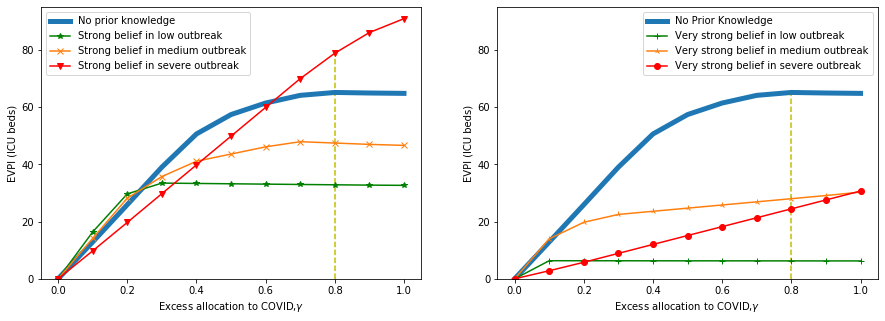

In [24]:
maxCol = 2;maxRow = 1
fig, axs = plt.subplots(maxRow, maxCol,figsize=(15, 5))
#fig.suptitle('Sensitivity of the Scaling Factor, $\gamma$ and Belief in States')
axs[0].plot(gammas,EVPINoPriorKnowledge,lw=5)
axs[0].plot(gammas,EVPIStrongBeliefInLowOutbreak,marker='*',color='g')
axs[0].plot(gammas,EVPIStrongBeliefInMediumOutbreak,marker='x')
axs[0].plot(gammas,EVPIStrongBeliefInSevereOutbreak,marker='v',color='r')

#axs[0].set_title('Strong Belief(0.5)')
#axs[0].set_xlabel('Scaling Factor,$\gamma$ ')
axs[0].set_xlabel('Excess allocation to COVID,$\gamma$ ')
axs[0].set_ylabel('EVPI (ICU beds)')
axs[0].legend(['No prior knowledge','Strong belief in low outbreak','Strong belief in medium outbreak','Strong belief in severe outbreak'])
axs[0].set_ylim([0, 95])
ymin = 0
ymax = 80
axs[0].vlines(0.8, ymin, ymax, colors='y', linestyles='--', label='EVPXI')

axs[1].plot(gammas,EVPINoPriorKnowledge,lw=5)
axs[1].plot(gammas,EVPIVeryStrongBeliefInLowOutbreak,marker='+',color='g')
axs[1].plot(gammas,EVPIVeryStrongBeliefInMediumOutbreak,marker='2')
axs[1].plot(gammas,EVPIVeryStrongBeliefInSevereOutbreak,marker='o',color='r')

#axs[1].set_title('Very Strong Belief(0.8)')
#axs[1].set_xlabel('Scaling Factor,$\gamma$ ')
axs[1].set_xlabel('Excess allocation to COVID,$\gamma$ ')
axs[1].set_ylabel('EVPI (ICU beds)')
axs[1].legend(['No Prior Knowledge','Very strong belief in low outbreak','Very strong belief in medium outbreak','Very strong belief in severe outbreak'])
axs[1].set_ylim([0, 95])
ymax = 65
axs[1].vlines(0.8, ymin, ymax, colors='y', linestyles='--', label='EVPI')

In [21]:
#Plots
plt.rcParams["figure.figsize"] = (10,6)

# 201 actions with 1 bed granularity
EVPI0 = [0.0, 12.63, 25.27, 37.91, 49.85, 59.17, 66.34, 69.06, 71.62, 72.69, 73.23]
EVPI1 = [0.0, 6.74, 6.73, 6.73, 6.73, 6.73, 6.73, 6.73, 6.73, 6.73, 6.73]
EVPI2 = [0.0, 2.88, 5.77, 8.66, 11.54, 14.43, 17.31, 20.2, 23.08, 25.97, 28.86]
EVPI3 = [0.0, 13.58, 22.59, 29.66, 30.78, 31.85, 32.91, 33.98, 35.05, 36.12, 37.19]
EVPI4 = [0.0, 16.17, 30.61, 36.28, 37.8, 38.16, 38.15, 38.15, 38.14, 38.14, 38.14]
EVPI5 = [0.0, 9.69, 19.38, 29.08, 38.77, 48.47, 58.16, 67.85, 76.88, 85.47, 92.35]
EVPI6 = [0.0, 13.73, 27.26, 37.48, 45.78, 51.47, 53.94, 56.39, 58.85, 60.52, 61.52]

# 1600 actions with 1 bed granularity

EVPI0 = [0.0, 125.07, 244.71, 309.38, 323.98, 333.29, 340.45, 343.17, 345.72, 346.79, 347.33]
EVPI1 = [0.0, 28.03, 28.03, 28.02, 28.02, 28.02, 28.02, 28.02, 28.02, 28.02, 28.02]
EVPI2 = [0.0, 48.51, 94.56, 135.55, 174.56, 213.57, 252.59, 291.6, 330.61, 369.63, 408.65]
EVPI3 = [0.0, 131.86, 140.88, 147.94, 149.06, 150.13, 151.2, 152.27, 153.33, 154.4, 155.47]
EVPI4 = [0.0, 121.63, 143.59, 149.26, 150.79, 151.13, 151.13, 151.12, 151.12, 151.11, 151.11]
EVPI5 = [0.0, 103.6, 206.15, 302.64, 396.85, 487.18, 512.12, 525.95, 536.59, 545.18, 552.05]
EVPI6 = [0.0, 135.07, 203.43, 213.65, 221.95, 227.63, 230.1, 232.55, 235.01, 236.68, 237.68]


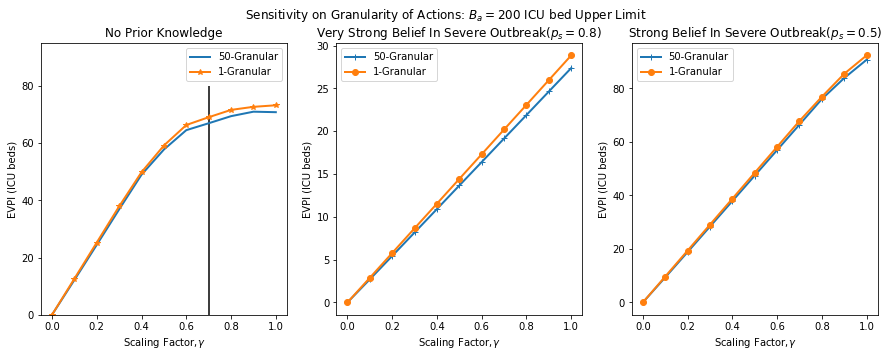

In [72]:
fig, axs = plt.subplots(maxRow, 3,figsize=(15, 5))
fig.suptitle('Sensitivity on Granularity of Actions: $B_a=$200 ICU bed Upper Limit')
EVPINoPriorKnowledge50Granular5Actions = [0.0, 12.17, 24.47, 36.85, 48.98, 57.77, 64.54, 66.95, 69.43, 70.99, 70.82]
EVPINoPriorKnowledge1Granular201Actions = [0.0, 12.63, 25.27, 37.91, 49.85, 59.17, 66.34, 69.06, 71.62, 72.69, 73.23]
axs[0].plot(gammas,EVPINoPriorKnowledge50Granular5Actions,lw=2)
axs[0].plot(gammas,EVPINoPriorKnowledge1Granular201Actions,marker='*',lw=2)
axs[0].set_ylabel('EVPI (ICU beds)')
axs[0].set_title('No Prior Knowledge')
axs[0].set_xlabel('Scaling Factor,$\gamma$ ')
axs[0].legend(['50-Granular','1-Granular'])
axs[0].set_ylim([0, 95])
ymin=0; ymax=80


EVPIVeryStrongBeliefInSevereOutbreak50Granular5Actions= [0.0, 2.7, 5.43, 8.17, 10.91, 13.66, 16.4, 19.15, 21.89, 24.64, 27.38]
EVPIVeryStrongBeliefInSevereOutbreak1Granular201Actions = [0.0, 2.88, 5.77, 8.66, 11.54, 14.43, 17.31, 20.2, 23.08, 25.97, 28.86]


axs[1].plot(gammas,EVPIVeryStrongBeliefInSevereOutbreak50Granular5Actions,marker='+',lw=2)
axs[1].plot(gammas,EVPIVeryStrongBeliefInSevereOutbreak1Granular201Actions,marker='o',lw=2)

axs[1].set_title('Very Strong Belief In Severe Outbreak($p_s = 0.8$)')
axs[1].set_xlabel('Scaling Factor,$\gamma$ ')
axs[1].set_ylabel('EVPI (ICU beds)')
axs[1].legend(['50-Granular','1-Granular'])

EVPIStrongBeliefInSevereOutbreak50Granular5Actions=[0.0, 9.37, 18.84, 28.36, 37.89, 47.42, 56.95, 66.48, 76.02, 83.88, 90.71]
EVPIStrongBeliefInSevereOutbreak1Granular201Actions=[0.0, 9.69, 19.38, 29.08, 38.77, 48.47, 58.16, 67.85, 76.88, 85.47, 92.35]
axs[2].plot(gammas,EVPIStrongBeliefInSevereOutbreak50Granular5Actions,marker='+',lw=2)
axs[2].plot(gammas,EVPIStrongBeliefInSevereOutbreak1Granular201Actions,marker='o',lw=2)

axs[2].set_title('Strong Belief In Severe Outbreak($p_s = 0.5$)')
axs[2].set_xlabel('Scaling Factor,$\gamma$ ')
axs[2].set_ylabel('EVPI (ICU beds)')
axs[2].legend(['50-Granular','1-Granular'])
#axs[1].set_ylim([0, 95])

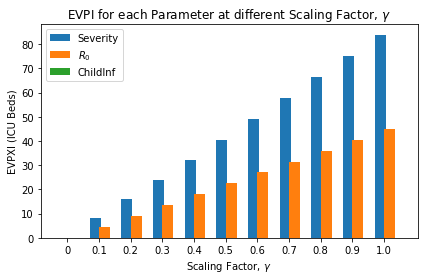

In [24]:
#Individual PArameter's EVPI Compared

labels2 = ['0', '0.1', '0.2', '0.3', '0.4','0.5', '0.6', '0.7', '0.8','0.9', '1.0']


#Flatten from 2D  to 1-D
EVPISeverity = list(chain.from_iterable(EVPISeverity))

EVPIR0 = list(chain.from_iterable(EVPIR0))

EVPIChildInf = list(chain.from_iterable(EVPIChildInf))

x = np.arange(len(labels2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, EVPISeverity, width, label='Severity',color='orange')
rects2 = ax.bar(x + width/2, EVPIR0, width, label='$R_0$')
rects3 = ax.bar(x + (width), EVPIChildInf, width, label='ChildInf')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EVPI (ICU Beds)')
ax.set_xlabel('Scaling Factor, $\gamma$')
ax.set_title('EVPI for each Parameter at different Scaling Factor, $\gamma$')
ax.set_xticks(x)
ax.set_xticklabels(labels2)
ax.legend()
fig.tight_layout()


<h2>Compute EVPXI</h2>

In [25]:

numGammas = len(gammas)
budgetsevpxi = list(gammas)
EVcertntyfalse = [0]*numberOfActions # Strictly used to compute expected value of removing uncertainty for hypothesis x rather than all the hypothesis

EVPXI=[[0 for i in range(numOfStates)] for j in range(numGammas) ]

countgammaPoints = 0
for gm in range(numGammas):#For each scaling factor (gamma)
    scaleFactor = gammas[gm]
    updatedPayoffs = generateNewPayoffs(scaleFactor)
    #print(updatedPayoffs)
    a = np.array(updatedPayoffs)
    for action in range(numberOfActions):
        currentPayoffs = a[action,:]
        EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
    EVDecisionUncertainty = min(abs(np.array(EVuncertnty))) # Expected Value of Decision Under Uncertainty
    #print(EVDecisionUncertainty)
    
    
    #Compute EVXPI for each State of nature
    for belief in range(numOfStates):
        currentBelief = beliefInState[belief]
        tempState = beliefInState.copy()
        falseBelief = 1 - currentBelief
        del tempState[belief]
        #print(tempState)
        newOtherBeliefs = renormaliseBeliefs(np.array(tempState),falseBelief)
        #print(newOtherBeliefs)
        currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
        
        
        absDifferenceWithBudget = abs(np.array(currActionsperState))
        currentStateOptimal = min(absDifferenceWithBudget)
        #print(currActionsperState)
        #print(absDifferenceWithBudget)
        #print(f"Current optimal is: ",currentStateOptimal)
        firstTermOfEVxCertainty = currentStateOptimal*currentBelief
        
        otherActionsPayoff = copy.deepcopy(updatedPayoffs) # Make a copy of the original payoff matrix, https://realpython.com/copying-python-objects/
        #print(payoffs)
        #print(otherActionsPayoff)
        #otherActionsPayof = removeCurrentPayoffs(otherActionsPayoff,belief) #Remove the Payoff for the state whose EVPXI is being computed
        
        #del otherActionsPayoff[belief]
       
        for action in range(numberOfActions):
            toArray = np.array(otherActionsPayoff)
            currPayoffFalse = toArray[action,:]
            cpayoffFalse = list(currPayoffFalse).copy()
            #print(len(cpayoffFalse))
            del  cpayoffFalse[belief]
            #print(len(cpayoffFalse))
            EVcertntyfalse[action] = EVUncertainty(cpayoffFalse,newOtherBeliefs)
        
        EVDecisionCertaintyFalse = min(abs(np.array(EVcertntyfalse))) # Expected Value of Decision Under Certainty For EVPXI
        secondTermofEVxCertainty = falseBelief * EVDecisionCertaintyFalse
        EVCertaintyx = firstTermOfEVxCertainty + secondTermofEVxCertainty
        #print(EVCertaintyx)
        evpxi =  abs(EVCertaintyx - EVDecisionUncertainty)
        EVPXI[gm][belief] = evpxi
        #print(evpxi)
        #EVPXI[belief] = EVCertaintyx - EVDecisionUncertainty
    countgammaPoints = countgammaPoints + 1
    #print(f" gm: {gammas[gm]}")
#print(f" EVPXIs: {np.array(EVPXI)}")
        

In [26]:
print ((EVPXI[8]))


[2.842170943040401e-14, 5.684341886080802e-14, 0.0, 2.842170943040401e-14, 2.842170943040401e-14, 5.684341886080802e-14, 0.0, 2.842170943040401e-14, 3.6000000000000227, 2.842170943040401e-14, 2.842170943040401e-14, 5.684341886080802e-14, 2.842170943040401e-14, 1.462000000000046, 4.023750000000035, 4.0, 10.000000000000028, 6.000000000000057, 0.0, 2.842170943040401e-14, 2.842170943040401e-14, 0.8642800000000079, 5.000000000000028, 4.5, 1.6000000000000227, 4.0, 2.3999999999999773]


In [27]:
print(f" EVPXIs: {numOfStates}")

 EVPXIs: 27


In [48]:
print(len(EVPXI[7]))

27


<h3> Plots </h3>

In [27]:
#Plot helper functions
def ICUBeds(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1)

formatter = FuncFormatter(ICUBeds)

Text(10, 9.000000000000028, 'Maximum EVPXI')

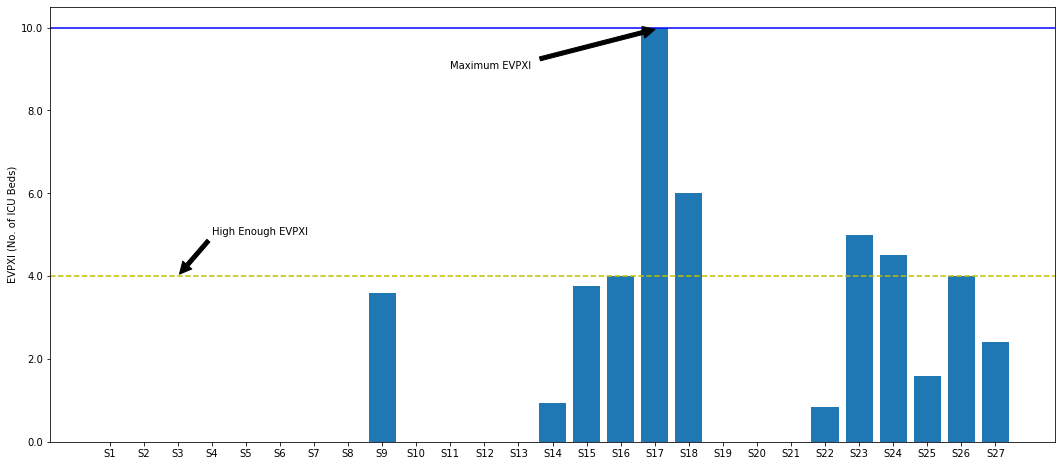

In [28]:
#Plot EVPXI of the budget with largest EVPI
evpxi = EVPXI[10] #Select the gamma to plot
x = np.arange(numOfStates)
#x = gammas
if analysisType != "All":
    fig, ax = plt.subplots(figsize=(8, 5))
else:
    fig, ax = plt.subplots(figsize=(18, 8))
ax.yaxis.set_major_formatter(formatter)
#plt.bar(x, abs(np.array(evpxi)))
plt.bar(x, evpxi)
plt.xticks(x, labels)
#plt.title(f'EVPXI at $\gamma={1.0}$ and with Strong believe ($p_s = 0.5 $) in Severe Outbreak')
#plt.xlabel('Hypothesis')
plt.ylabel('EVPXI (No. of ICU Beds)')
maxevpxi = max(evpxi)
highEnoughEVPXI = 0.4*maxevpxi

plt.axhline(y=4, color='y', linestyle='--',label='High Enough EVPXI')
plt.axhline(y=10, color='b', linestyle='-',label='Max EVPXI')
plt.annotate('High Enough EVPXI', xy=(2, highEnoughEVPXI), xytext=(3, highEnoughEVPXI + 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Maximum EVPXI', xy=(16.2, maxevpxi), xytext=(10, maxevpxi-1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
#plt.legend()
#plt.grid(color='b', linestyle='--', linewidth=1,which='major', axis='y')

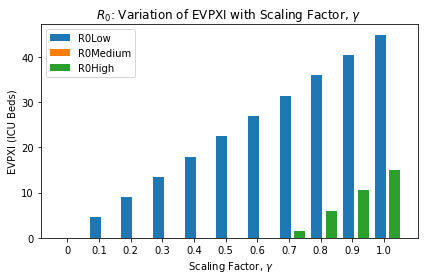

In [53]:

labels2 = ['0', '0.1', '0.2', '0.3', '0.4','0.5', '0.6', '0.7', '0.8','0.9', '1.0']

Low = np.round(np.array(EVPXI)[:,0],1)
Medium = np.array(EVPXI)[:,1]
High  = np.array(EVPXI)[:,2]
men_means = [20, 34, 30]
women_means = [25, 32, 34]

x = np.arange(len(labels2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, Low, width, label=labels[0])
rects2 = ax.bar(x + width/2, Medium, width, label=labels[1])
rects3 = ax.bar(x + (width), High, width, label=labels[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EVPXI (ICU Beds)')
ax.set_xlabel(' Scaling Factor, $\gamma$')
ax.set_title('$R_0$: Variation of EVPXI with Scaling Factor, $\gamma$')
ax.set_xticks(x)
ax.set_xticklabels(labels2)
ax.legend()



fig.tight_layout()

plt.show()

In [358]:
df.tail()

,0
0,0.00
1,65.00
2,982.89


In [365]:
print(EVPXI[1:])

[[6.0, 2.0, 5.0], [12.0, 4.0, 11.399999999999977], [18.0, 6.0, 18.600000000000023], [24.000000000000057, 8.0, 25.80000000000001], [30.0, 10.5, 33.0], [36.0, 13.199999999999989, 40.19999999999999], [42.0, 15.900000000000034, 47.900000000000034], [48.0, 18.599999999999966, 56.599999999999966], [54.0, 21.30000000000001, 65.30000000000001], [60.0, 24.0, 74.0]]


In [368]:
print(np.array(EVPXI)[:,0])


[ 0.  6. 12. 18. 24. 30. 36. 42. 48. 54. 60.]


In [74]:
print(EVPXI[10])

[0.0, 0.2675249400000155, 2.842170943040401e-14, 0.0, 1.767524940000044, 2.842170943040401e-14, 2.842170943040401e-14, 0.0, 3.5999999999999943, 0.0, 1.767524940000044, 0.2675249400000155, 2.842170943040401e-14, 5.762822249999971, 8.354023650000016, 4.0, 10.0, 5.999999999999972, 0.0, 0.0, 0.0, 1.0, 7.151351200000022, 4.851363719999995, 1.6000000000000227, 4.0, 2.3999999999999773]


(4, 4)


In [107]:
df['actions'] = actionNames
df.set_index("actions",drop=True,inplace=True)

In [108]:
df.tail()

,0,1,2
actions,,,
CI05,0,0,0.000000
CI95,0,0,6.262394
Mean,0,0,1.544850


Text(0.5, 1.0, 'Region1: Payoffs (Costs) for each action')

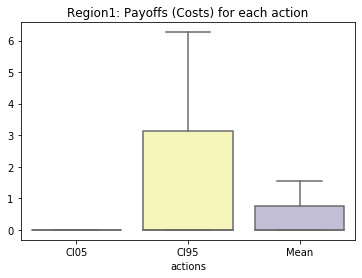

In [109]:
df = df.transpose()
ax = sns.boxplot(data=df,palette="Set3")
plt.title(f'{region}: Payoffs (Costs) for each action')

Text(0.5, 1.0, 'Region1: Payoffs (Costs) for each action')

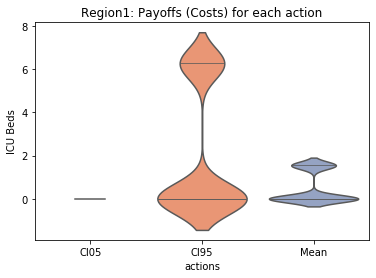

In [110]:
ax = sns.violinplot(data=df,palette="Set2",scale="count", inner="stick",
                    scale_hue=False, bw=.2)
plt.ylabel('ICU Beds')
plt.title(f'{region}: Payoffs (Costs) for each action')

<H1> Study the EVXPI of each of R_0, Severity and Child Infectiousness </H1>

In [152]:
#Functions for batch processing of VoI
def computeEVPI(budget):
    global EVuncertnty,EVDecisionUncertainty
    EVcertain=0 
    # Compute Expected Value of Decision Under Uncertainty
    for action in range(numberOfActions):
        currentPayoffs = a[action,:]
        EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
    EVDecisionUncertainty = min(abs(np.array(EVuncertnty))) 
    
    #Compute EVcertainty
    for belief in range(numOfStates):
        currentBelief = beliefInState[belief]
        currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
        absDifferenceWithBudget = abs(np.array(currActionsperState) - budget)
        currentStateOptimal = min(absDifferenceWithBudget)
        indexofMin=absDifferenceWithBudget.argmin()
        optimumActionForThisState = a[indexofMin][belief]*currentBelief #EMV of optimal decision without considering budget
        #print(f" Hypothesis = {belief},Best Action = Purchase {getActionName(indexofMin) }({int(round(a[indexofMin][belief],0))}) ICU beds")
        thisEV = currentStateOptimal*currentBelief
        EVcertain = EVcertain  + thisEV
    evpi = abs(EVcertain - EVDecisionUncertainty)
    return evpi

def EVPIForBudgets(budgetpoints):
    currentBudget = 0
    numBudgetPoints = len(budgetPoints)
    EVPIForBudgets = [0]*numBudgetPoints
    for budget in budgetPoints:
        EVPIForBudgets[currentBudget] = computeEVPI(budget)
        currentBudget = currentBudget + 1
    return EVPIForBudgets

def computeEVPXI(budget):
    global EVuncertnty,EVDecisionUncertainty
    EVPXIfx = [0]*numOfStates
    for action in range(numberOfActions):
        currentPayoffs = a[action,:]
        EVuncertnty[action] = EVUncertainty(currentPayoffs,beliefInState)
    EVDecisionUncertainty = min(abs(np.array(EVuncertnty) - budget)) # Expected Value of Decision Under Uncertainty
    
    #Compute EVXPI for each State of nature/hypothesis
    for belief in range(numOfStates):
        currentBelief = beliefInState[belief]
        tempState = beliefInState.copy()
        falseBelief = 1 - currentBelief
        del tempState[belief]
        #print(tempState)
        newOtherBeliefs = renormaliseBeliefs(np.array(tempState),falseBelief)
        #print(newOtherBeliefs)
        currActionsperState = a[:,belief] #Get payoffs for each action corresponding to current state of nature
        
        
        absDifferenceWithBudget = abs(np.array(currActionsperState) - budget)
        currentStateOptimal = min(absDifferenceWithBudget)
        
        firstTermOfEVxCertainty = currentStateOptimal*currentBelief
        
        otherActionsPayoff = copy.deepcopy(payoffs) # Make a copy of the original payoff matrix, https://realpython.com/copying-python-objects/
        otherActionsPayof = removeCurrentPayoffs(otherActionsPayoff,belief) #Remove the Payoff for the state whose EVPXI is being computed
        #print(otherActionsPayof)
        for action in range(numberOfActions):
            toArray = np.array(otherActionsPayof)
            currPayoffFalse = toArray[action,:]
            EVcertntyfalse[action] = EVUncertainty(currPayoffFalse,newOtherBeliefs)
        
        EVDecisionCertaintyFalse = min(abs(np.array(EVcertntyfalse) - budget)) # Expected Value of Decision Under Certainty For EVPXI
        secondTermofEVxCertainty = falseBelief * EVDecisionCertaintyFalse
        EVCertaintyx = firstTermOfEVxCertainty + secondTermofEVxCertainty
        #EVPXI[countBugetPoints][belief] = abs(EVCertaintyx - EVDecisionUncertainty)
        EVPXIfx[belief] = EVCertaintyx - EVDecisionUncertainty
    return EVPXIfx

def EVPXIForBudgets(budgetpoint):
    currentBudget = 0
    numBudgetPoints = len(budgetPoints)
    EVPXIForBudgets = [0]*numBudgetPoints
    for budget in budgetPoints:
        EVPXIForBudgets[currentBudget] = computeEVPXI(budget)
        currentBudget = currentBudget + 1
    return EVPXIForBudgets
    
        

In [73]:
print(EVPXI[10])

[0.0, 0.2675249400000155, 2.842170943040401e-14, 0.0, 1.767524940000044, 2.842170943040401e-14, 2.842170943040401e-14, 0.0, 3.5999999999999943, 0.0, 1.767524940000044, 0.2675249400000155, 2.842170943040401e-14, 5.762822249999971, 8.354023650000016, 4.0, 10.0, 5.999999999999972, 0.0, 0.0, 0.0, 1.0, 7.151351200000022, 4.851363719999995, 1.6000000000000227, 4.0, 2.3999999999999773]


In [154]:
#Run EVPI first to find the budget with highest EVPI
budgetPoints = range(0,1700,5)
budgets = list(budgetPoints)
numBudgetPoints = len(budgetPoints)
EVPI = [0]*numBudgetPoints
EVPI = EVPIForBudgets(budgets)
#Prepare to run EVPXI with the budget with maximum EVPI
indexOfMaxEVPI = np.array(EVPI).argmax()
budgetWithMaxEVPI = budgets[indexOfMaxEVPI]
print (f"Max EVPI: {max(EVPI)}, Budget with Max EVPI: {budgetWithMaxEVPI} ICU beds, Index of the budget: {indexOfMaxEVPI}")
#print (EVPI)
budget = budgetWithMaxEVPI #Use this to run EVPXI for each parameter

TypeError: list indices must be integers or slices, not tuple

In [155]:
#Prepare plot windows
#Initialise variables
numOfRegions = len(allRegions)
numOfAnalysis = len(allAnalysisTypes)
regCount = 0; analysisCount = 0;countBugetPoints = 0


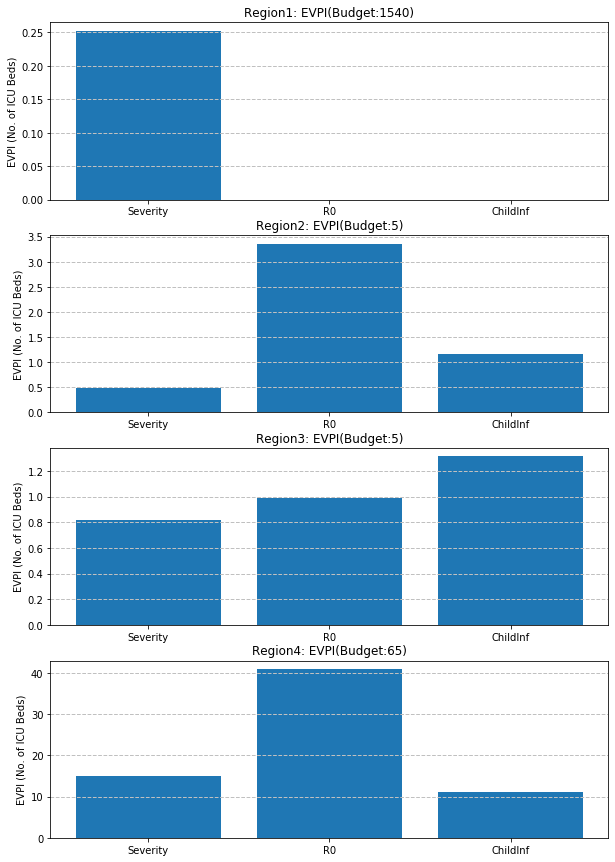

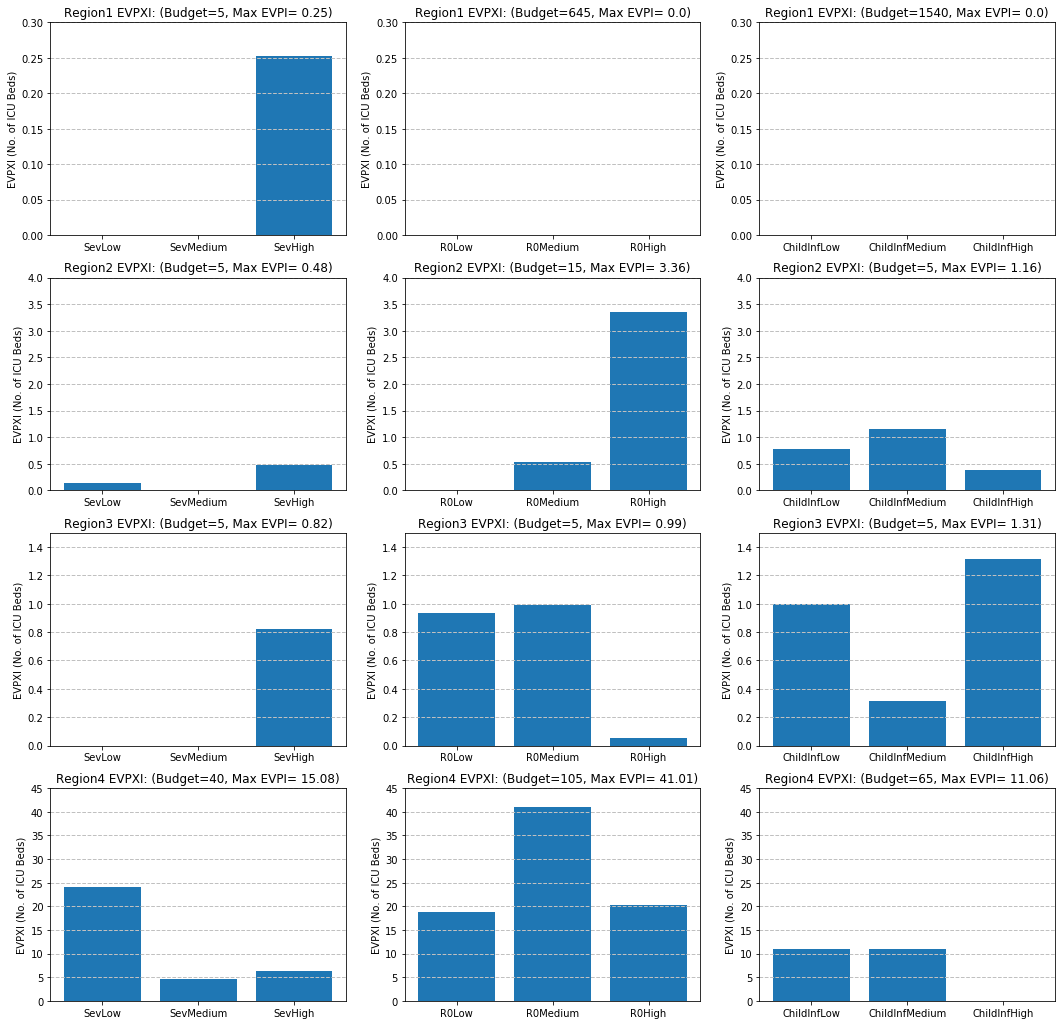

In [158]:
#Try running all experiments in one go
fig, axs = plt.subplots(numOfRegions,figsize=(10, 15))
numSubplotsCount=1


#fig2 = plt.figure(figsize=(20, 20))
fig2, axs2 = plt.subplots(numOfRegions, numOfAnalysis,figsize=(18, 18))
EVPI2 =[[0 for i in range(numOfAnalysis)] for j in range(numOfRegions) ] #EVPI = [numOfRegions][numOfAnalysis]

#EVPXIForBudgets2 = [[0]*numOfAnalysis]*numOfRegions
#fig.suptitle('EVPI plots')
 
for reg in allRegions: #For each region carry out Severity, R0, ChildInfectiousness, and Combined PArameter Analysis of VoI
    if reg=='Region1':
        ylimit = 0.3
    elif reg=='Region2':
        ylimit = 4
    elif reg=='Region3':
        ylimit = 1.5
    elif reg=='Region4':
        ylimit = 45 
    for analysis in allAnalysisTypes:
        payoffs = []
        beliefInState = []
        labels = []
        loadExperiment(reg,analysis)
        payoffNum = np.array(payoffs).shape
        numOfStates = len(beliefInState)
        numberOfActions = payoffNum[0]
        EVuncertnty=[0]*numberOfActions
        EVcertain = 0
        EVcertntyfalse = [0]*numberOfActions # Strictly used to compute expected value of removing uncertainty for hypothesis x rather than all the hypothesis
        EVPXIForBudgets2 = [[[0 for i in range(numOfStates)] for j in range(numOfAnalysis) ] for k in range(numOfRegions)]
        #validateInputs()
        a = np.array(payoffs)
        EVPI = [0]*numBudgetPoints
        EVPI = EVPIForBudgets(budgets)
        
        #Prepare to run EVPXI with the budget with maximum EVPI
        indexOfMaxEVPI = np.array(EVPI).argmax()
        maxEVPI = max(EVPI)
        budgetWithMaxEVPI = budgets[indexOfMaxEVPI]
        budget = budgetWithMaxEVPI #Use this to run EVPI and EVPXI for each parameter
        EVPI2[regCount] [analysisCount]= computeEVPI(budget)
        EVPXIForBudgets2[regCount] [analysisCount]= computeEVPXI(budget)
        x = labels
        #print(labels)
       
        numSubplotsCount = numSubplotsCount +1
        
        #axs2[regCount,analysisCount].plot(x,EVPXIForBudgets2[regCount][analysisCount],ls='--',color ='r')#axs2[regCount,analysisCount]
        axs2[regCount][analysisCount].bar(x, EVPXIForBudgets2[regCount][analysisCount])
        
        axs2[regCount][analysisCount].set_title(f'{reg} EVPXI: (Budget={budgetWithMaxEVPI}, Max EVPI= {round(EVPI[indexOfMaxEVPI],2)})')
        axs2[regCount][analysisCount].set_ylabel('EVPXI (No. of ICU Beds)')
        axs2[regCount][analysisCount].grid(color='#C0C0C0', linestyle='--', linewidth=1,which='major', axis='y')
        a=max(EVPXIForBudgets2[regCount])
        thisRegionsylim = max(a)  #The largest value across all parameters for this region
        #axs2[regCount,analysisCount].set_ylim([0, thisRegionsylim + 0.1*thisRegionsylim])
        axs2[regCount,analysisCount].set_ylim([0, ylimit])
        analysisCount = analysisCount + 1
    x = allAnalysisTypes
    #print(EVPI2)
    axs[regCount].bar(x, EVPI2[regCount])
    axs[regCount].set_ylabel('EVPI (No. of ICU Beds)')
    axs[regCount].grid(color='#C0C0C0', linestyle='--', linewidth=1,which='major', axis='y')
    axs[regCount].set_title(reg + ': EVPI(' + 'Budget:' + str(budget) + ')')
    
    regCount = regCount + 1
    analysisCount = 0
regCount=0
#print (EVPI)

In [80]:
print(EVPI2)

[[0.25247879780000027, 0, 0], [0, 0, 0]]


In [79]:
print(np.array(EVPXIForBudgets2))
regCount=0

[[[0.        0.        0.2524788]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]

 [[0.        0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]]


In [116]:
a=max(EVPXIForBudgets2[0])

print(max(a))

0.25247879780000027


In [119]:
print(axs2[1][1])

AxesSubplot(0.398529,0.125;0.227941x0.343182)


Text(0, 0.5, 'Probability Density')

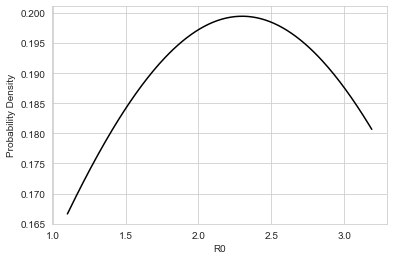

In [9]:
np.random.seed(0)

# import required libraries
from scipy.stats import norm

import seaborn as sb
 
# Creating the distribution
data = np.arange(1.1,3.2,0.01)
pdf = norm.pdf(data , loc = 2.3 , scale = 2 )
 
#Visualizing the distribution
 
sb.set_style('whitegrid')
sb.lineplot(data, pdf , color = 'black')
plt.xlabel('R0')
plt.ylabel('Probability Density')

Text(0, 0.5, 'Probability Density')

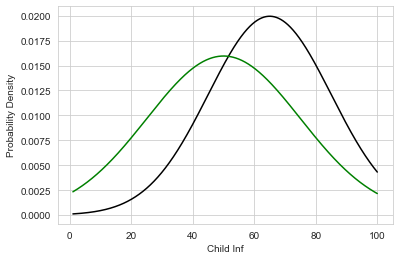

In [16]:
# Creating the distribution
data = np.arange(1,100,0.01)
pdf = norm.pdf(data , loc = 65 , scale = 20 ) # loc= mean, scale = standard deviation
pdf2 = norm.pdf(data , loc = 50 , scale = 25 )
#Visualizing the distribution
 
sb.set_style('whitegrid')
sb.lineplot(data, pdf , color = 'black')
sb.lineplot(data, pdf2 , color = 'green')
plt.xlabel('Child Inf')
plt.ylabel('Probability Density')

[196.  110.  178.    8.9]


[196.  110.  178.    8.9]
